In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import loompy
import shoji
import logging
from tqdm import tqdm
import sys
import os
import cytograph as cg
import cytograph.plotting as cgplot
import fdb
fdb.api_version(620)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=20)
%load_ext line_profiler

In [5]:
import pickle

In [2]:
db = shoji.connect()

In [3]:

## Create workshape
db = shoji.connect()
db.test = shoji.Workspace()
ws = db.test

## We create a yx dimension to work in the spatial domain
ws.cells = shoji.Dimension(shape=None)
ws.yx = shoji.Dimension(shape=2)

## Coordinates of track are defined as being specific to a cell, existing on 
## the yx plane and having an undetermined length
ws.Coord = shoji.Tensor("uint8", ("cells", "yx", None,), jagged=True)

## Add 5 cells in a loop, each having a different length track
NCells = 5
for i in range(1, NCells+1):
    Coord = np.ones([1, 2, i], dtype=np.int8)
#     Coord = np.ones([1, 2, 5], dtype=np.int8) ## Can be run without issue
    ws.cells.append({'Coord': Coord}) ## Add the track

In [4]:
Coord

array([[[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]], dtype=int8)

In [4]:
%%time
x = db.samples.TenX89_1.Expression[:]

CPU times: user 5.08 s, sys: 1.25 s, total: 6.32 s
Wall time: 11.7 s


In [20]:
((age >= 6) & (age <= 8)).sum()

1092482

(array([ 60647.,      0.,      0.,  11976.,      0., 199384., 853632.,
         93643., 344959., 198831., 111819., 166691., 168222., 242118.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

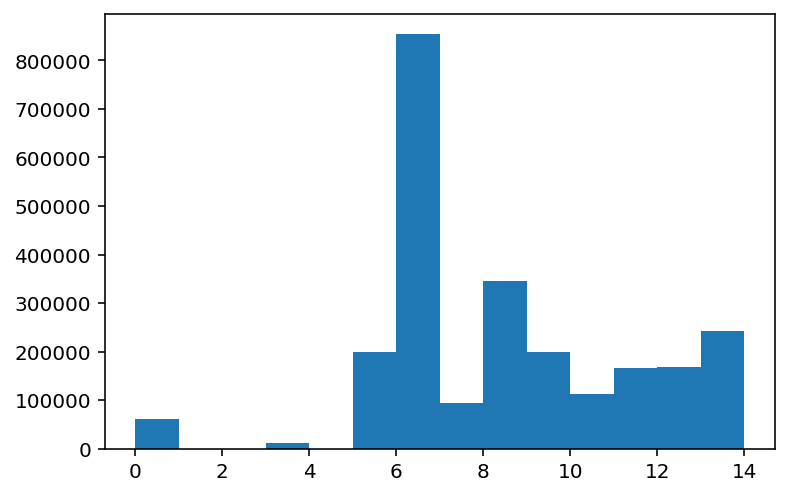

In [15]:
plt.hist(age, bins=np.arange(15))

In [ ]:
# Import all updated samples
d = "/Users/stelin/samples/"
for f in tqdm(os.listdir(d)):
    if f.upper().startswith("10X") and f.endswith(".loom"):
        name = "TenX" + f[3:-5]
        if name in db.samples:
            try:
                with loompy.connect(d + f) as ds:
                    n_cells = ds.shape[1]
                if db.samples[name].cells.length == n_cells:
                    continue
                del db.samples[name]
            except:
                print(f, "is broken")
                break
        db.samples[name] = shoji.Workspace()
        db.samples[name]._from_loom(d + f, ["", "unspliced"], fix_expression_dtype=True)

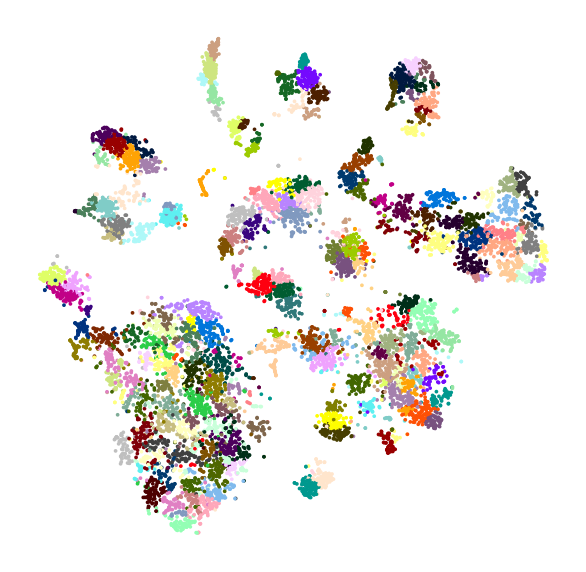

In [95]:
plt.figure(figsize=(5,5))
ws = db.builds.humandev.EarlyEmbryo
cgplot.scatterc(ws.Embedding[:], c=ws.Clusters[:], legend=None)
plt.axis("off")
None

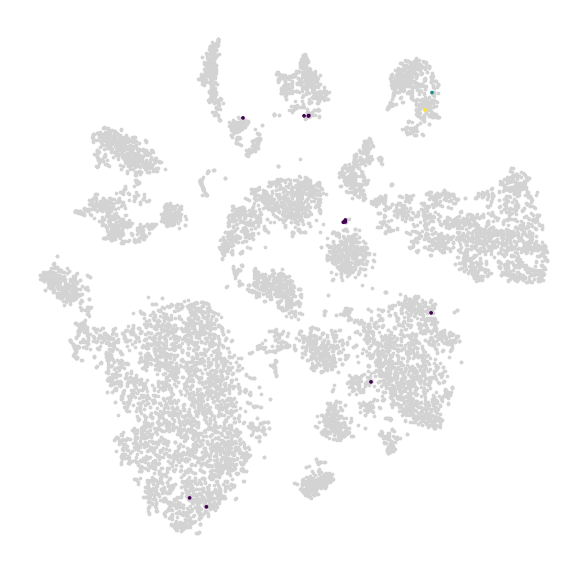

In [24]:
plt.figure(figsize=(5,5))
ws = db.builds.humandev.EarlyEmbryo
cgplot.scattern(ws.Embedding[:], c=ws.Expression[:, ws.Gene == "XIST"].T[0])
plt.axis("off")
None

In [109]:
import igraph
import leidenalg as la
ptypes = {
    "modularity": la.ModularityVertexPartition,
    "cpm": la.CPMVertexPartition,
    "surprise": la.SurpriseVertexPartition,
    "rb": la.RBConfigurationVertexPartition,
    "rber": la.RBERVertexPartition,
    "significance": la.SignificanceVertexPartition
}
method = ptypes["modularity"]
max_size = 100
resolution=1
rc = ws.ManifoldIndices[:]
g = igraph.Graph(ws.cells.length, list(zip(rc[:, 0].T.tolist(), rc[:, 1].T.tolist())), directed=False)
labels = np.array(la.find_partition(g, method, weights=ws.ManifoldWeights[:], max_comm_size=max_size, n_iterations=-1).membership)
#partition = la.find_partition(g, method, max_comm_size=max_size,n_iterations=-1)
#labels = np.array(partition.membership)

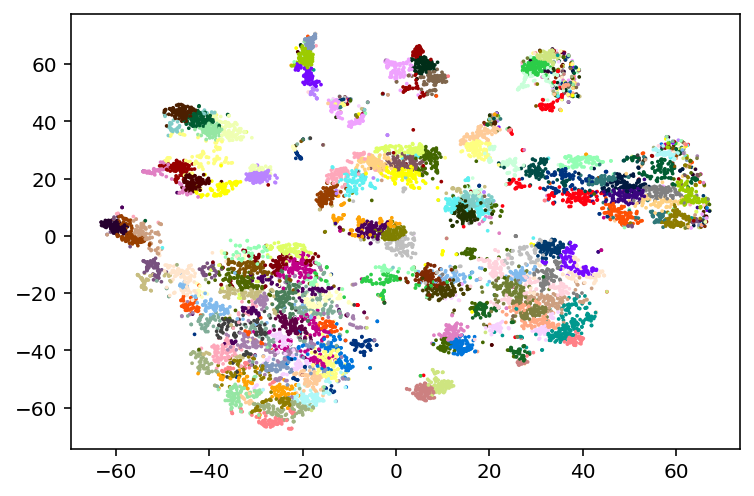

In [110]:
cgplot.scatterc(ws.Embedding[:], c=labels, legend=None)

In [3]:
import inspect
import importlib

def get_decorators(function):
    """Returns list of decorators names

    Args:
        function (Callable): decorated method/function

    Return:
        List of decorators as strings

    Example:
        Given:

        @my_decorator
        @another_decorator
        def decorated_function():
            pass

        >>> get_decorators(decorated_function)
        ['@my_decorator', '@another_decorator']

    """
    source = inspect.getsource(function)
    index = source.find("def ")
    return [
        line.strip()
        for line in source[:index].strip().splitlines()
        if line.strip()[0] == "@"
    ]

In [4]:
import re
def google(text):
        """
        Convert `text` in Google-style docstring format to Markdown
        to be further converted later.
        """
        def googledoc_sections(match):
            section, body = match.groups('')
            if not body:
                return match.group()
            body = textwrap.dedent(body)
            section = section.title()
            if section in ('Args', 'Attributes'):
                body = re.compile(
                    r'^([\w*]+)(?: \(([\w.,=\[\] -]+)\))?: '
                    r'((?:.*)(?:\n(?: {2,}.*|$))*)', re.MULTILINE).sub(
                    lambda m: _ToMarkdown._deflist(*_ToMarkdown._fix_indent(*m.groups())),
                    inspect.cleandoc('\n' + body)
                )
            elif section in ('Returns', 'Yields', 'Raises', 'Warns'):
                body = re.compile(
                    r'^()([\w.,\[\] ]+): '
                    r'((?:.*)(?:\n(?: {2,}.*|$))*)', re.MULTILINE).sub(
                    lambda m: _ToMarkdown._deflist(*_ToMarkdown._fix_indent(*m.groups())),
                    inspect.cleandoc('\n' + body)
                )
            # Convert into markdown sections. End underlines with '='
            # to avoid matching and re-processing as Numpy sections.
            return f'\n{section}\n-----=\n{body}'

        text = re.compile(r'^([A-Z]\w+):$\n'
                          r'((?:\n?(?: {2,}.*|$))+)', re.MULTILINE).sub(googledoc_sections, text)
        return text

def deindent(s):
    lines = s.split("\n")
    n_tabs = 0
    for c in lines[1]:
        if c == "\t":
            n_tabs += 1
        else:
            break
    return "\n".join(l[n_tabs:] for l in lines)


class CytographDocs:
    def _repr_html_(self):
        html = ""
        current = ""
        for cls in cg.Module.__subclasses__():
            mod = ".".join(cls.__module__.split(".")[:2])
            alg = cls.__name__
            if mod != current:
                current = mod
                html += "<h2>Module '<span style='color: crimson'>" + mod + "</span>'</h2>"
                module = importlib.import_module('cytograph.' + cls.__module__.split(".")[1])
                if module.__doc__ is not None:
                    html += "<p>" + deindent(module.__doc__) + "</p>"
 
            html += f"<h3 style='color: green'>{alg}</h3>"
 
            decs = get_decorators(cls.fit)
            if any("@requires" in d for d in decs):
                html += "<strong>Required tensors</strong>"
                html += "<table><tr><th></th><th>dtype</th><th>dims</th></tr>"
                for dec in decs:
                    if "#" in dec:
                        dec = dec[dec.rindex("#") - 1:]
                    if "@requires" in dec:
                        items = dec[dec.index("("):dec.rindex(")")].split(",")
                        html += "<tr><td>" + items[0].strip('"()\' ') + "</td><td>" + items[1].strip('"()\' ') + "</td><td>" + dec[dec.index(",", dec.index(",") + 1):-1].strip('",\' ') + "</td><tr/>"
                html += "</table>"

            if any("@creates" in d for d in decs):
                html += "<strong>Created tensors</strong>"
                html += "<table><tr><th></th><th>dtype</th><th>dims</th></tr>"
                for dec in decs:
                    if "#" in dec:
                        dec = dec[dec.rindex("#") - 1:]
                    if ", indices=True" in dec:
                        dec = dec[:dec.index(", indices=True")]
                    if "@creates" in dec:
                        items = dec[dec.index("("):dec.rindex(")") + 1].split(",")
                        html += "<tr><td>" + items[0].strip('"()\' ') + "</td><td>" + items[1].strip('"()\' ') + "</td><td>" + dec[dec.index(",", dec.index(",") + 1):-1].strip('",\' ') + "</td><tr/>"
                html += "</table>"

            html += f"Syntax: <strong>{alg}</strong>" + " {"
            html += ", ".join([f"<strong>{parm.name}</strong>: {str(parm).split(':')[1]}" for name, parm in inspect.signature(cls.__init__).parameters.items() if name not in ("self", "args", "kwargs")])
            html += "}<br/>"
            html += "<p>&nbsp;</p>"
            if cls.__doc__ is not None:
                html += "<p>" + deindent(cls.__doc__) + "</p>"

            if cls.__init__.__doc__ is not None:
                html += "<pre>" + deindent(cls.__init__.__doc__) + "</pre>"
            html += "<p>&nbsp;</p>"
            html += "<p>&nbsp;</p>"
            
            
        return html
CytographDocs()

,dtype,dims
SelectedFeatures,bool,"(""genes"",)"
MeanExpression,float64,"(""clusters"", ""genes"")"
,dtype,dims
Linkage,float32,"(None, 4)"
LinkageOrdering,uint32,"(""clusters"",)"
,dtype,dims
Embedding,float32,"(""cells"", 2)"
ManifoldIndices,uint32,"(None, 2)"
ManifoldWeights,float32,(None)
,dtype,dims


CPU times: user 9.98 s, sys: 148 ms, total: 10.1 s
Wall time: 4.82 s


(-76.64536056518554, 85.91090927124023, -78.5972354888916, 78.50387458801269)

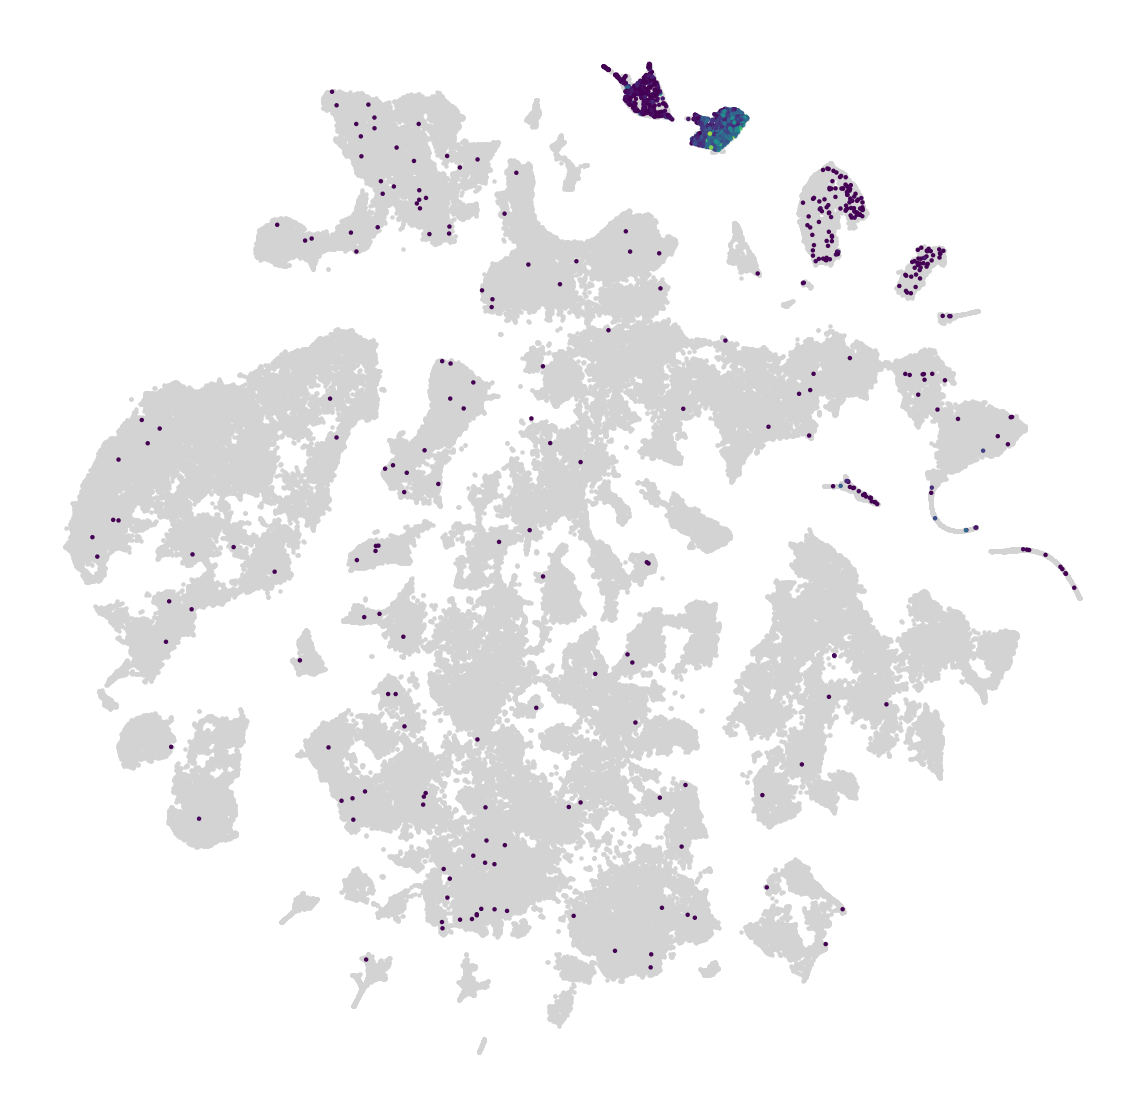

In [5]:
%%time
ws = db.builds.mousedev.Mousedev
xy = ws.Embedding[:]
plt.figure(figsize=(10,10))
cgplot.scattern(xy, c=ws.Expression[:, ws.Gene == "Mrc1"][:, 0], s=5)
plt.axis("off")

In [7]:
%%time
import igraph
g = igraph.Graph(ws.cells.length, list(zip(rc[:, 0].T.tolist(), rc[:, 1].T.tolist())), directed=False, edge_attrs={'weight': w})

CPU times: user 458 ms, sys: 44.6 ms, total: 503 ms
Wall time: 503 ms
Compiler : 124 ms


In [106]:
ws

TypeError: 'NoneType' object is not subscriptable

Workspace with 0 workspaces, 3 dimensions and 39 tensors:
  cells <Dimension of shape 241387>
  clusters <Dimension of shape 218>
  genes <Dimension of shape 31053>
  Accession <Tensor Accession dtype='string' dims=('genes',), shape=(31053,), chunks=(31,)>
  Age <Tensor Age dtype='string' dims=('cells',), shape=(241387,), chunks=(31,)>
  CellCycleFraction <Tensor CellCycleFraction dtype='float32' dims=('cells',), shape=(241387,), chunks=(250,)>
  Chemistry <Tensor Chemistry dtype='string' dims=('cells',), shape=(241387,), chunks=(31,)>
  Chromosome <Tensor Chromosome dtype='string' dims=('genes',), shape=(31053,), chunks=(31,)>
  ClusterID <Tensor ClusterID dtype='uint32' dims=('clusters',), shape=(218,), chunks=(250,)>
  Clusters <Tensor Clusters dtype='uint32' dims=('cells',), shape=(241387,), chunks=(250,)>
  Deviance <Tensor Deviance dtype='float32' dims=('genes',), shape=(31053,), chunks=(250,)>
  Donor <Tensor Donor dtype='string' dims=('cells',), shape=(241387,), chunks=(31,)>
 

In [5]:
%%time
ws = db.builds.mousedev.Mousedev
indices = [np.arange(ws.ManifoldIndices.shape[0]), np.arange(2)]
chunk_sizes = (150, 100)
# Figure out which chunks need to be read
addresses_per_dim = [np.unique(ind // sz) for ind, sz in zip(indices, chunk_sizes)]
# All combinations of addresses along each dimension
addresses = np.array(np.meshgrid(*addresses_per_dim)).T.reshape(-1, len(indices))
chunks = shoji.io.read_chunks_multibatch(ws._db.transaction, ws._subdir, (2, "ManifoldIndices"), addresses)

CPU times: user 12.3 s, sys: 5.33 s, total: 17.6 s
Wall time: 30.1 s


In [88]:
values = np.random.randint(0, 100, size=(5430514, 2))

In [89]:
def parsechunks(n):
    # Figure out which chunks need to be written
    addresses_per_dim = [np.unique(ind // sz) for ind, sz in zip(indices, chunk_sizes)]
    # All combinations of addresses along each dimension
    addresses = np.array(np.meshgrid(*addresses_per_dim)).T.reshape(-1, len(indices))
    chunks = []
    count = 0
    for address in tqdm(addresses):
        # At this point, we have a chunk address, and we have the indices
        # into the whole tensor. We need to figure out the relevant indices for this chunk,
        # and their offsets in the chunk, so that we can place the right values at the right place in
        # the chunk for writing. We also need to construct a mask if the chunk is not fully covered
        chunk_indices = [ind[(ind // sz) == a] - a * sz for a, ind, sz in zip(address, indices, chunk_sizes)]
        chunk = np.empty_like(values, shape=chunk_sizes)
        # These are the indices into the whole tensor that fall within the chunk
        tensor_indices = [ind[(ind // sz) == a] for a, ind, sz in zip(address, indices, chunk_sizes)]
        # Now figure out which part of the values tensor they correspond to (always a dense sub-tensor)
        starts = [(i < min(j)).sum() for i, j in zip(indices, tensor_indices)]
        lengths = [len(j) for j in tensor_indices]
        values_slices = tuple(slice(s, s + l) for s, l in zip(starts, lengths))

        # Finally, copy the correct subtensor of values into the right slots in the chunk
        chunk[np.ix_(*chunk_indices)] = values[values_slices]

        mask = np.ones(chunk_sizes, dtype=bool)
        mask[np.ix_(*chunk_indices)] = False
        if np.any(mask):
            chunks.append(np.ma.masked_array(chunk, mask=mask))
        else:
            chunks.append(chunk)
        count += 1
        if count > n:
            return chunks
        
def parsechunks_new(n):
    # Figure out which chunks need to be written
    addresses_per_dim = [np.unique(ind // sz) for ind, sz in zip(indices, chunk_sizes)]
    # All combinations of addresses along each dimension
    addresses = np.array(np.meshgrid(*addresses_per_dim)).T.reshape(-1, len(indices))
    chunks = []
    count = 0
    for address in tqdm(addresses):
        # At this point, we have a chunk address, and we have the indices
        # into the whole tensor. We need to figure out the relevant indices for this chunk,
        # and their offsets in the chunk, so that we can place the right values at the right place in
        # the chunk for writing. We also need to construct a mask if the chunk is not fully covered
        chunk_indices = []
        tensor_indices = []
        lengths = []
        for a, ind, sz in zip(address, indices, chunk_sizes):
            start = np.searchsorted(ind, a * sz, side='left')
            end = np.searchsorted(ind, (a + 1) * sz, side='left')
            chunk_indices.append(ind[start:end] - a * sz)
            tensor_indices.append(ind[start])
            lengths.append(end - start)
        chunk = np.empty_like(values, shape=chunk_sizes)
        # Now figure out which part of the values tensor they correspond to (always a dense sub-tensor)
        starts = []
        for ind, min_ind in zip(indices, tensor_indices):
            start = np.searchsorted(ind, min_ind, side='left')
            starts.append(start)
        values_slices = tuple(slice(s, s + l) for s, l in zip(starts, lengths))

        # Finally, copy the correct subtensor of values into the right slots in the chunk
        chunk[np.ix_(*chunk_indices)] = values[values_slices]

        mask = np.ones(chunk_sizes, dtype=bool)
        mask[np.ix_(*chunk_indices)] = False
        if np.any(mask):
            chunks.append(np.ma.masked_array(chunk, mask=mask))
        else:
            chunks.append(chunk)
        count += 1
        if count > n:
            return chunks
        



In [90]:
lp = LineProfiler()
lp_wrapper = lp(parsechunks_new)
lp_wrapper(10)
lp.print_stats()

  0%|          | 10/36204 [00:00<00:12, 2956.03it/s]

Timer unit: 1e-06 s

Total time: 0.125207 s
File: <ipython-input-89-bd523b3e024c>
Function: parsechunks_new at line 35

Line #      Hits         Time  Per Hit   % Time  Line Contents
    35                                           def parsechunks_new(n):
    36                                               # Figure out which chunks need to be written
    37         1     120475.0 120475.0     96.2      addresses_per_dim = [np.unique(ind // sz) for ind, sz in zip(indices, chunk_sizes)]
    38                                               # All combinations of addresses along each dimension
    39         1        200.0    200.0      0.2      addresses = np.array(np.meshgrid(*addresses_per_dim)).T.reshape(-1, len(indices))
    40         1          1.0      1.0      0.0      chunks = []
    41         1          1.0      1.0      0.0      count = 0
    42        11       1068.0     97.1      0.9      for address in tqdm(addresses):
    43                                                 

In [99]:
np.all(parsechunks(10)[7] == parsechunks_new(10)[7])

  0%|          | 10/36204 [00:00<00:06, 5642.81it/s]


True

In [96]:
parsechunks_new(1)

  0%|          | 1/36204 [00:00<00:14, 2511.56it/s]


[masked_array(
   data=[[79, 80, --, ..., --, --, --],
         [38, 51, --, ..., --, --, --],
         [40, 68, --, ..., --, --, --],
         ...,
         [4, 6, --, ..., --, --, --],
         [22, 40, --, ..., --, --, --],
         [72, 60, --, ..., --, --, --]],
   mask=[[False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         ...,
         [False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True]],
   fill_value=999999),
 masked_array(
   data=[[84, 7, --, ..., --, --, --],
         [22, 59, --, ..., --, --, --],
         [47, 42, --, ..., --, --, --],
         ...,
         [91, 56, --, ..., --, --, --],
         [77, 29, --, ..., --, --, --],
         [96, 67, --, ..., --, --, --]],
   mask=[[False, False,  True, ...,  True,  True,  True],
         [False, Fa

# Load all samples into a workspace

In [15]:
#del db.samples
#db.samples = shoji.Workspace()
d = "/Users/stelin/samples/"
for f in tqdm(os.listdir(d)):
    if not f.endswith(".loom"):
        continue
    name = f[:-5]
    if f.startswith("10X") or f.startswith("10x"):
        name = "TenX" + name[3:]
    if name not in db.samples:
        db.samples[name] = shoji.Workspace()
    if "Expression" not in db.samples[name]:
        print(name)
        try:
            db.samples[name]._from_loom(d + f, fix_expression_dtype=True, layers=("", "unspliced"))
        except OSError as e:
            print(name, e)

  3%|▎         | 34/1327 [00:00<00:16, 78.44it/s]

TenX174_8


 11%|█         | 144/1327 [01:31<00:33, 34.98it/s] 

TenX206_8


 34%|███▍      | 448/1327 [04:02<00:24, 35.77it/s]  

TenX248_1


 69%|██████▊   | 909/1327 [06:47<00:09, 43.19it/s]  

TenX218_1


 95%|█████████▌| 1264/1327 [07:54<00:01, 44.32it/s]

TenX217_2


100%|██████████| 1327/1327 [08:56<00:00,  2.47it/s]


In [14]:
for sample in db.samples._workspaces():
    if "Expression" not in db.samples[sample]:
        print(sample)

TenX174_8
TenX206_8
TenX217_2
TenX218_1
TenX248_1


In [ ]:
# Load reference data into workspaces
db.refdb = shoji.Workspace()
db.refdb.mouse = shoji.Workspace()
db.refdb.mouse.development = shoji.Workspace()
db.refdb.mouse.development_agg = shoji.Workspace()
db.refdb.mouse.adult = shoji.Workspace()
db.refdb.mouse.adult_agg = shoji.Workspace()
db.refdb.human = shoji.Workspace()
db.refdb.human.development = shoji.Workspace()
db.refdb.human.development_agg = shoji.Workspace()
db.refdb.human.adult = shoji.Workspace()
db.refdb.human.adult_agg = shoji.Workspace()

In [4]:
db.refdb.human_development._from_loom("/Users/stelin/cytograph/20200702_human_dev/data/Allbrain.loom", fix_expression_dtype=True)

2020-10-04 23:11:35,273 - INFO - GeneSummaryStatistics: Computing summary statistics for genes
2020-10-04 23:11:40,361 - INFO - GeneSummaryStatistics: Done.
2020-10-04 23:11:40,368 - INFO - SummaryStatistics: Saving mean expression per gene as float32 tensor 'MeanExpression'
2020-10-04 23:11:40,369 - INFO - SummaryStatistics: Saving standard deviation per gene as float32 tensor 'StdevExpression'
2020-10-04 23:11:41,920 - INFO - DoubletFinder: Creating artificial doublets
2020-10-04 23:12:01,100 - INFO - DoubletFinder: Feature selection and dimensionality reduction
2020-10-04 23:12:01,108 - INFO - FeatureSelectionByVariance: Fitting CV vs mean
2020-10-04 23:12:12,699 - INFO - FeatureSelectionByVariance: Done.
2020-10-04 23:12:18,002 - INFO - DoubletFinder: Initializing NN structure with k = 60
2020-10-04 23:12:19,236 - INFO - DoubletFinder: Finding the doublet score threshold
2020-10-04 23:12:21,794 - INFO - DoubletFinder: Finding doublet neighbors
2020-10-04 23:12:21,820 - INFO - Doubl

(-88.63347816467285, 100.74948310852051, -92.30757637023926, 92.74987525939942)

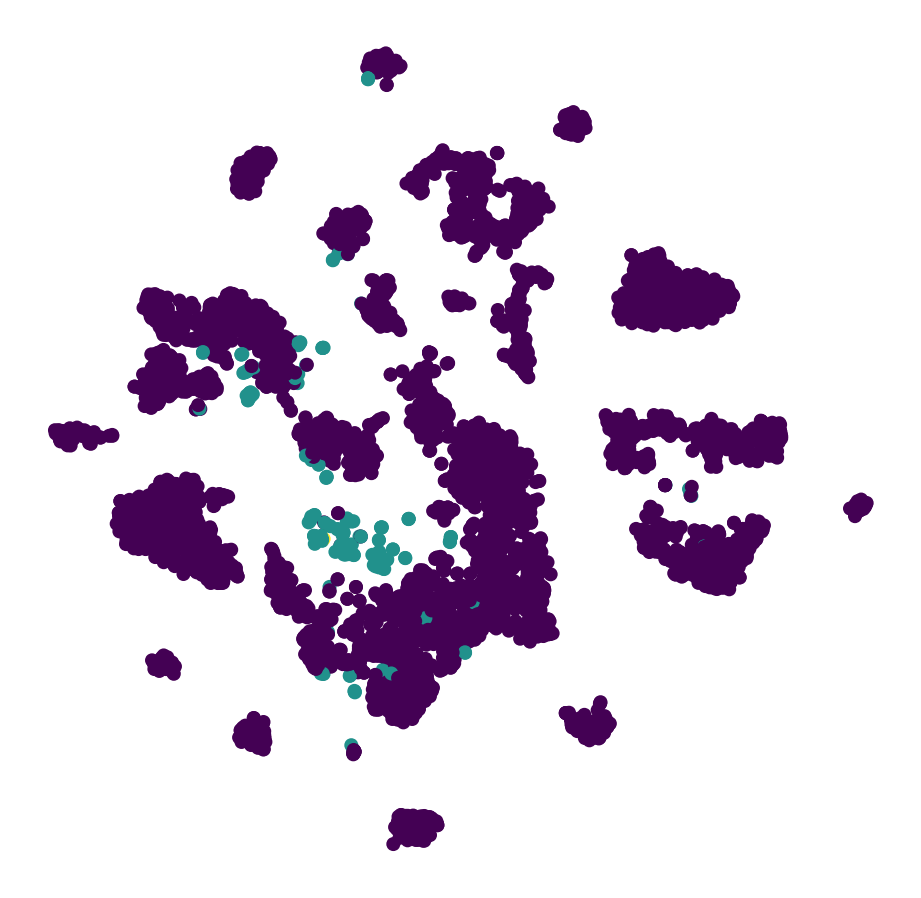

In [4]:
mu, sd = cg.GeneSummaryStatistics().fit_save(ws)
score, flag = cg.DoubletFinder().fit_save(ws)
plt.figure(figsize=(8,8))
plt.scatter(ws.TSNE[:][:, 0], ws.TSNE[:][:,1], c=flag)
plt.axis("off")

In [5]:
cg.CellSummaryStatistics(cg.human).fit_save(ws)

2020-10-04 23:13:15,562 - INFO - SummaryStatistics: Loading 'Expression' and 'Unspliced' tensors
2020-10-04 23:13:24,883 - INFO - SummaryStatistics: Computing summary statistics for cells
2020-10-04 23:13:25,398 - INFO - SummaryStatistics: Average number of non-zero genes 4756
2020-10-04 23:13:25,398 - INFO - SummaryStatistics: Average total UMIs 15865
2020-10-04 23:13:25,399 - INFO - SummaryStatistics: Average mitochondrial UMI fraction 0.39%
2020-10-04 23:13:25,399 - INFO - SummaryStatistics: Average unspliced fraction 74.01%
2020-10-04 23:13:25,399 - INFO - SummaryStatistics: Average cell cycle UMI fraction 0.11%
2020-10-04 23:13:25,479 - INFO - SummaryStatistics: Saving nnz as uint32 tensor 'NGenes'
2020-10-04 23:13:25,479 - INFO - SummaryStatistics: Saving n_UMIs as uint32 tensor 'TotalUMIs'
2020-10-04 23:13:25,480 - INFO - SummaryStatistics: Saving mitochondrial UMI fraction as float32 tensor 'MitoFraction'
2020-10-04 23:13:25,480 - INFO - SummaryStatistics: Saving unspliced frac

(array([1636, 4424, 5197, ..., 5080, 4235, 1446]),
 array([ 3770., 12644., 15072., ..., 14922., 10426.,  2246.], dtype=float32),
 array([0.        , 0.00126542, 0.00019904, ..., 0.00053612, 0.01304431,
        0.00133571], dtype=float32),
 array([0.76472149, 0.76376147, 0.75218949, ..., 0.75023455, 0.68012661,
        0.71193232]),
 array([0.00185676, 0.00166087, 0.00072983, ..., 0.00067015, 0.00124688,
        0.00133571], dtype=float32))

<ipython-input-28-40977a8292ad>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(ws[:].MeanExpression, ws[:].StdevExpression / ws[:].MeanExpression, s=5)


(0.1, 100)

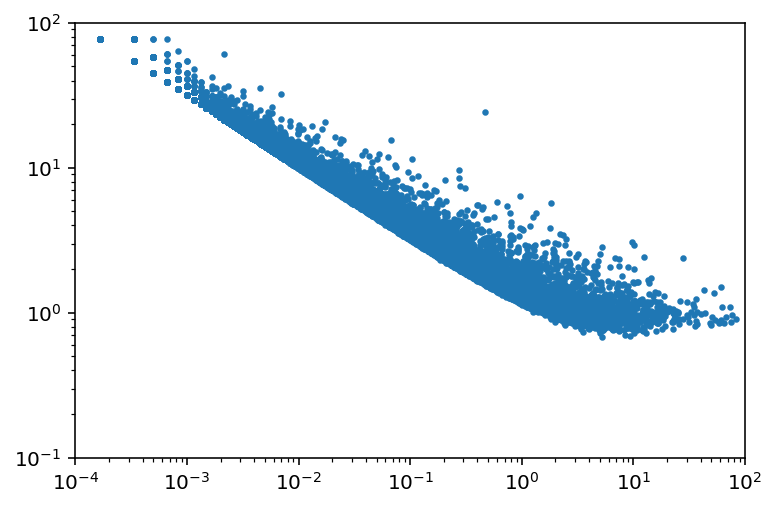

In [28]:
plt.scatter(ws[:].MeanExpression, ws[:].StdevExpression / ws[:].MeanExpression, s=5)
plt.yscale("log")
plt.xscale("log")
plt.xlim(.0001,100)
plt.ylim(0.1,100)

In [20]:
gb = ws.cells.groupby("Clusters")

In [22]:
gb.mean("TotalUMI")

(array([ 3,  6,  0,  5,  7,  8,  4, 10, 13,  1,  2,  9, 11, 12]),
 array([16417.93045113, 16205.75110132, 15594.41492537, 16103.18358531,
        15546.26405868, 14513.13612565, 16826.64049587, 16860.21981424,
        15782.61538462, 16099.84304207, 15760.92363636, 15205.0183727 ,
        15643.89735099, 14946.6292517 ]))

In [24]:
gb = ws[ws.Clusters == 1].groupby("PassedQC_UnsplicedRatio")

In [25]:
gb.mean("TotalUMI")

(array([1, 0], dtype=uint8), array([16173.46829268,  1006.66666667]))

In [32]:
gb.count.__self__.__class__

shoji.groupby.GroupViewBy

In [194]:
from typing import *
import functools

class ResultHolder:
    def __init__(self, args, stored) -> None:
        self.args = args
        self.stored = stored
    
def creates(name: str, dtype: str, dims: Tuple[Optional[Union[str, int]], ...]) -> Callable:
    """
    Declare the tensors that are created by a Cytograph fit() method, when save=True

    Usage:
        class Test:
            @creates("Expression", "float32", ("cells", "genes"))
            @creates("Age", "string", ())
            def fit(self, ws, save) -> None:
                # body of method
                return (expression, age)  # Note order must match order of decorators
                # If fit() was called with save=True, the return values will be saved as the indicated tensors

    Remarks:
        The decorator can only be applied to a method that takes a shoji.WorkspaceManager object as first argument
    """
    def decorator(func: Callable) -> Callable:
        @functools.wraps(func)
        def wrapper(self, ws: shoji.WorkspaceManager, *args, **kwargs):
            result = func(self, ws, *args, **kwargs)
            if "save" not in kwargs or not kwargs["save"]:
                return result
            if not isinstance(result, ResultHolder):
                result = ResultHolder(result, result)
            ws[name] = shoji.Tensor(dtype, dims, inits=result.args[-1])
            if len(result.args) == 1:
                return result.stored
            return ResultHolder(result.args[:-1], result.stored)
        return wrapper
    return decorator


In [198]:
class Test:
    @requires("Expression", "float32", ("cells", "genes"))
    @requires("Age", "string", ())
    @creates("Test", "uint8", ("genes",))
    @creates("Test2", "uint8", ("genes",))
    def fit(ws, self, arg1, arg2, save=False) -> None:
        return np.zeros(33538, dtype="uint8"), np.ones(33538, dtype="uint8")

In [199]:
t = Test()

In [200]:
t.fit(ws, 1, 2, save=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([1, 1, 1, ..., 1, 1, 1], dtype=uint8))

In [172]:
ws

Workspace with 0 workspaces, 2 dimensions and 61 tensors:
  cells <Dimension of variable shape>
  genes <Dimension of shape 33538>
  Accession <Tensor Accession dtype='string' dims=('genes',), shape=(33538,)>
  Age <Tensor Age dtype='string' dims=(), shape=()>
  Ambiguous <Tensor Ambiguous dtype='uint16' dims=('cells', 'genes'), shape=(6031, 33538)>
  BpLength <Tensor BpLength dtype='int64' dims=(), shape=()>
  CDNAConc <Tensor CDNAConc dtype='float64' dims=(), shape=()>
  CellConc <Tensor CellConc dtype='int64' dims=(), shape=()>
  CellCycle <Tensor CellCycle dtype='float64' dims=('cells',), shape=(6031,)>
  CellCycleFraction <Tensor CellCycleFraction dtype='float32' dims=('cells',), shape=(6031,)>
  CellCycle_G1 <Tensor CellCycle_G1 dtype='float64' dims=('cells',), shape=(6031,)>
  CellCycle_G2M <Tensor CellCycle_G2M dtype='float64' dims=('cells',), shape=(6031,)>
  CellCycle_S <Tensor CellCycle_S dtype='float64' dims=('cells',), shape=(6031,)>
  CellID <Tensor CellID dtype='string' dims=('cells',), shape=(6031,)>
  Chemistry <Tensor Chemistry dtype='string' dims=(), shape=()>
  Chromosome <Tensor Chromosome dtype='string' dims=('genes',), shape=(33538,)>
  Clusters <Tensor Clusters dtype='int64' dims=('cells',), shape=(6031,)>
  Comment <Tensor Comment dtype='string' dims=(), shape=()>
  CreationDate <Tensor CreationDate dtype='string' dims=(), shape=()>
  Donor <Tensor Donor dtype='string' dims=(), shape=()>
  DoubletFinderFlag <Tensor DoubletFinderFlag dtype='int64' dims=('cells',), shape=(6031,)>
  DoubletFinderScore <Tensor DoubletFinderScore dtype='float64' dims=('cells',), shape=(6031,)>
  DoubletFlag <Tensor DoubletFlag dtype='uint8' dims=('cells',), shape=(6031,)>
  DoubletScore <Tensor DoubletScore dtype='float32' dims=('cells',), shape=(6031,)>
  End <Tensor End dtype='int64' dims=('genes',), shape=(33538,)>
  Expression <Tensor Expression dtype='float32' dims=('cells', 'genes'), shape=(6031, 33538)>
  FinalConc <Tensor FinalConc dtype='float64' dims=(), shape=()>
  Gene <Tensor Gene dtype='string' dims=('genes',), shape=(33538,)>
  IsCycling <Tensor IsCycling dtype='uint8' dims=('cells',), shape=(6031,)>
  LOOM_SPEC_VERSION <Tensor LOOM_SPEC_VERSION dtype='string' dims=(), shape=()>
  MT_ratio <Tensor MT_ratio dtype='float64' dims=('cells',), shape=(6031,)>
  MeanExpression <Tensor MeanExpression dtype='float32' dims=('genes',), shape=(33538,)>
  MeanTotalUMI <Tensor MeanTotalUMI dtype='float64' dims=(), shape=()>
  MitoFraction <Tensor MitoFraction dtype='float32' dims=('cells',), shape=(6031,)>
  NGenes <Tensor NGenes dtype='uint32' dims=('cells',), shape=(6031,)>
  PCA <Tensor PCA dtype='float32' dims=('cells', 50), shape=(6031, 50)>
  PCRCycles <Tensor PCRCycles dtype='int64' dims=(), shape=()>
  PassedQC <Tensor PassedQC dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_MT_ratio <Tensor PassedQC_MT_ratio dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_TotalUMI <Tensor PassedQC_TotalUMI dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_UMIPerGene <Tensor PassedQC_UMIPerGene dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_UnsplicedRatio <Tensor PassedQC_UnsplicedRatio dtype='uint8' dims=('cells',), shape=(6031,)>
  PassedQC_gobal <Tensor PassedQC_gobal dtype='uint8' dims=(), shape=()>
  RegionOfInterest <Tensor RegionOfInterest dtype='string' dims=(), shape=()>
  SampleName <Tensor SampleName dtype='string' dims=(), shape=()>
  Sex <Tensor Sex dtype='string' dims=(), shape=()>
  Species <Tensor Species dtype='string' dims=(), shape=()>
  Spliced <Tensor Spliced dtype='uint16' dims=('cells', 'genes'), shape=(6031, 33538)>
  Start <Tensor Start dtype='int64' dims=('genes',), shape=(33538,)>
  StdevExpression <Tensor StdevExpression dtype='float32' dims=('genes',), shape=(33538,)>
  Strand <Tensor Strand dtype='string' dims=('genes',), shape=(33538,)>
  TSNE <Tensor TSNE dtype='float32' dims=('cells', 2), shape=(6031, 2)>
  TargetNumCells <Tensor TargetNumCells dtype='int64' dims=(